In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Load the dataset
df = pd.read_csv("/content/drive/My Drive/NLP/Tweets.csv")

In [ ]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [ ]:
import re
def no_emo(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return (emoji_pattern.sub(r'', text))

In [ ]:
def clean_text(df):
    df['text'] =df['text'].apply(lambda x : x.lower().strip()) #case norm
    df['text'] =df['text'].apply(lambda x: re.sub("\S*@\S*\s?", '', x)) #email remove
    df['text'] =df['text'].apply(lambda x: re.sub(r'http\S+', '', x))# http remove
    df['text'].apply(no_emo)# remove emojis
    df['text'] =df['text'].apply(lambda x: re.sub('[^a-zA-Z\n\.]', ' ', x)) #Remove special characters, non-text characters
    df['text'] =df['text'].apply(lambda x:re.sub(r'([^\w\s]|_)+', ' ', x))#Remove repeated punctuations
    df['text'] =df['text'].apply(lambda x:re.sub(r'\s+', ' ',x))#Remove white spaces
    df['text'] = df['text'].apply(lambda x: re.sub(r'\bamp\b', '', x))

    df['text'] =df['text'].apply(lambda x:x.strip())

    return df

In [ ]:
df['labels'] = df["airline_sentiment"].apply(lambda x: 0 if x == "negative" else 1 if x == "neutral" else 2)

<Axes: xlabel='labels', ylabel='count'>

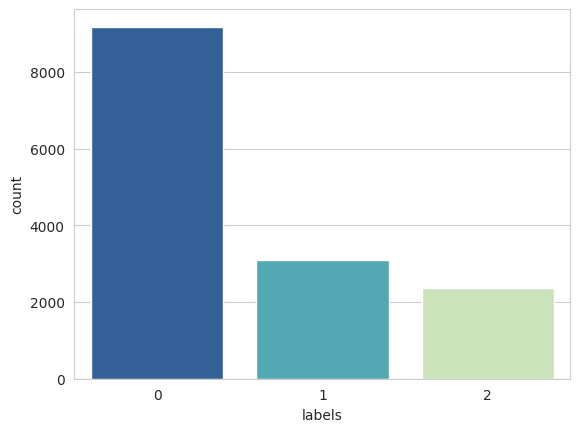

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
sns.countplot(x='labels',data=df, palette='YlGnBu_r')

<Axes: xlabel='airline_sentiment', ylabel='count'>

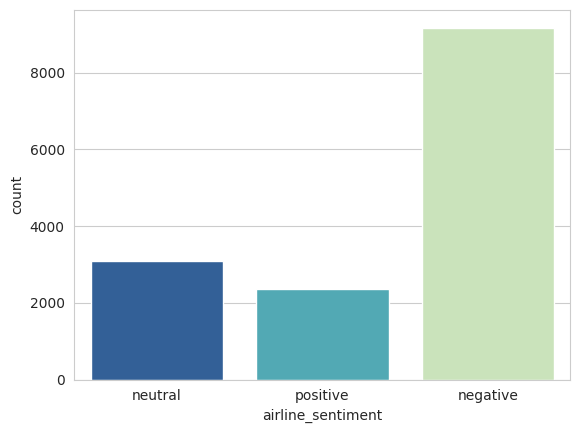

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
sns.countplot(x='airline_sentiment',data=df, palette='YlGnBu_r')

In [ ]:
df = clean_text(df)

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,labels
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,what said,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),1
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus you ve added commercials to the experienc...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),2
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,i didn t today must mean i need to take anothe...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,it s really aggressive to blast obnoxious ente...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,and it s a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0


<Axes: xlabel='airline', ylabel='count'>

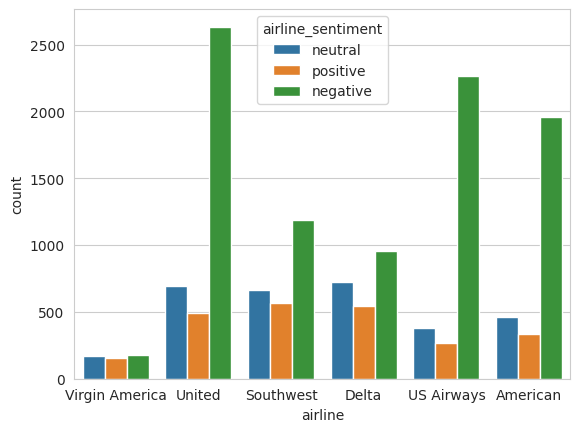

In [ ]:
sns.countplot(data=df,x='airline',hue='airline_sentiment')

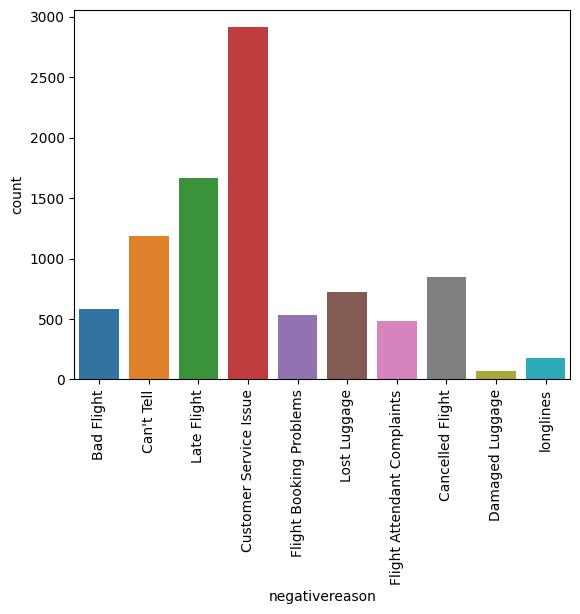

In [ ]:
sns.countplot(data=df,x='negativereason')
plt.xticks(rotation=90);

In [ ]:
# top 20 most common words function
def common_words(rev):
    texts = df[df['airline_sentiment'] == rev]['text'].values
    vec = CountVectorizer(stop_words='english').fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key = lambda x: x[1], reverse=True)[:20]

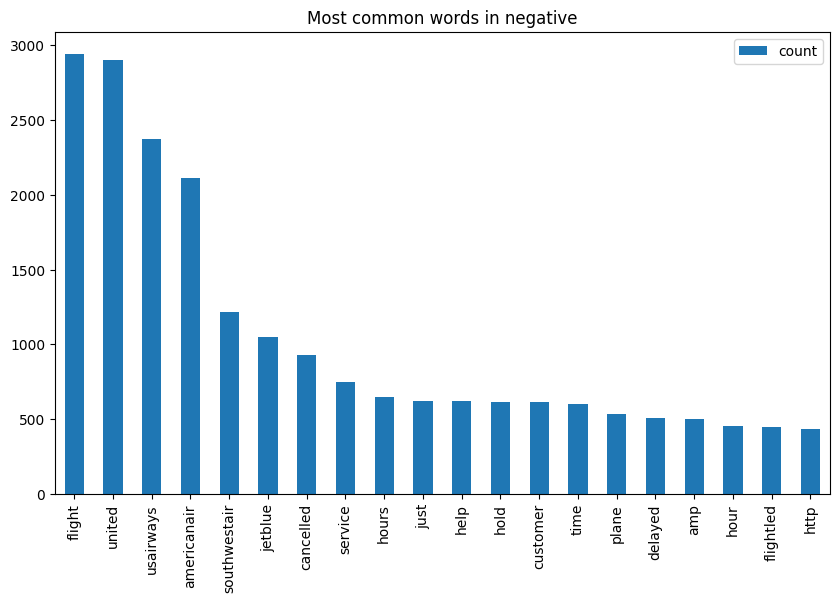

In [ ]:
top_neg = dict(common_words('negative'))
pd.DataFrame.from_dict(top_neg, orient='index', columns=['count']).plot(kind='bar', figsize=(10, 6),title = 'Most common words in negative');

In [ ]:
top_neg = dict(common_words('negative'))
pd.DataFrame.from_dict(top_neg, orient='index', columns=['count']).plot(kind='bar', figsize=(10, 6),title = 'Most common words in negative');

In [ ]:
x = df['text']
y = df['labels']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfv = TfidfVectorizer(min_df=3,  max_features=None,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


TfidfVectorizer(min_df=3, ngram_range=(1, 2), smooth_idf=1,
                stop_words='english', strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [ ]:
X_train_tfv = tfv.transform(X_train)
X_test_tfv = tfv.transform(X_test)

In [ ]:
X_train_tfv

<11712x6718 sparse matrix of type '<class 'numpy.float64'>'
	with 107467 stored elements in Compressed Sparse Row format>

**SVR**

In [ ]:
# Train an SVR model with a linear kernel on the training data
svr = SVR(kernel='linear')
svr.fit(X_train_tfv, y_train)

SVR(kernel='linear')

In [ ]:
df.shape

(14640, 16)

In [ ]:
# Predict the labels of the testing data and convert the predictions to binary labels
y_pred = svr.predict(X_test_tfv)

In [ ]:
y_pred

array([ 2.67959372, -0.07248822,  0.47770272, ..., -0.00398649,
        0.92544784, -0.11417098])

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
def report(model):
    preds = model.predict(X_test_tfv)
    preds = pd.Series(preds).apply(lambda x: 0 if x < 0.5 else (1 if x < 1.5 else 2))
    print(classification_report(y_test,preds))
report(svr)

              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1817
           1       0.40      0.65      0.49       628
           2       0.85      0.34      0.48       483

    accuracy                           0.70      2928
   macro avg       0.70      0.60      0.60      2928
weighted avg       0.76      0.70      0.70      2928



In [ ]:
df['text'][1]

'plus you ve added commercials to the experience tacky'

In [ ]:
df['labels'][1]

2

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
text = "plus you ve added commercials to the experience tacky"
X_test = tfv.transform([text])
pred = svr.predict(X_test)

In [ ]:
pred

array([0.91708239])

In [ ]:
if(pred < 0.5):
  print('0')
elif(pred<1.5):
  print('2')
else:
  print('1')

2


**NAIVE BAYES**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tfv,y_train)

MultinomialNB()

In [ ]:
report(nb)

              precision    recall  f1-score   support

           0       0.71      0.98      0.83      1817
           1       0.73      0.25      0.37       628
           2       0.85      0.36      0.51       483

    accuracy                           0.72      2928
   macro avg       0.77      0.53      0.57      2928
weighted avg       0.74      0.72      0.68      2928



In [ ]:
pred = nb.predict(X_test)
if(pred < 0.5):
  print('0')
elif(pred<1.5):
  print('2')
else:
  print('1')

0


**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(max_iter=1000)
log.fit(X_train_tfv,y_train)

LogisticRegression(max_iter=1000)

In [ ]:
report(log)

              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1817
           1       0.65      0.44      0.53       628
           2       0.83      0.58      0.68       483

    accuracy                           0.78      2928
   macro avg       0.76      0.65      0.69      2928
weighted avg       0.77      0.78      0.76      2928



**LINEAR SVC**

In [ ]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train_tfv,y_train)

LinearSVC()

In [ ]:
report(svc)

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1817
           1       0.58      0.53      0.55       628
           2       0.76      0.62      0.68       483

    accuracy                           0.77      2928
   macro avg       0.72      0.68      0.70      2928
weighted avg       0.76      0.77      0.76      2928



**RANDOM FOREST**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_tfv, y_train)
y_pred_rf = clf_rf.predict(X_test_tfv)
y_pred_rf = [1 if pred > 0.5 else 0 for pred in y_pred_rf]
report(clf_rf)

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1817
           1       0.58      0.44      0.50       628
           2       0.71      0.55      0.62       483

    accuracy                           0.74      2928
   macro avg       0.69      0.63      0.65      2928
weighted avg       0.73      0.74      0.73      2928



**DECISION TREE**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train_tfv, y_train)
y_pred_dt = clf_dt.predict(X_test_tfv)
y_pred_dt = [1 if pred > 0.5 else 0 for pred in y_pred_dt]

In [ ]:
report(clf_dt)

              precision    recall  f1-score   support

           0       0.79      0.80      0.80      1817
           1       0.47      0.46      0.46       628
           2       0.58      0.55      0.56       483

    accuracy                           0.69      2928
   macro avg       0.61      0.60      0.61      2928
weighted avg       0.69      0.69      0.69      2928



**OPINION WORDS**

In [ ]:
data = pd.read_csv("/content/drive/My Drive/NLP/Tweets.csv")

In [ ]:
data['labels'] = data["airline_sentiment"].apply(lambda x: 0 if x == "negative" else 1 if x == "neutral" else 2)

In [ ]:
data = clean_text(data)

In [ ]:
import nltk
from nltk.corpus import opinion_lexicon
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

nltk.download('opinion_lexicon')
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Assuming your dataset is a pandas DataFrame called 'df' with a column called 'preprocessed_text'
def opinion(text):
    words = nltk.word_tokenize(text)
    opinion_count = 0
    for word in words:
        if word in positive_words:
            opinion_count += 1
        elif word in negative_words:
            opinion_count -= 1
    return 1 if opinion_count > 0 else 0

df['label'] = df['text'].apply(opinion)

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.1, random_state=42)

X_train_opinion = []
for text in X_train:
    words = nltk.word_tokenize(text)
    opinion_count = 0
    for word in words:
        if word in positive_words:
            opinion_count += 1
        elif word in negative_words:
            opinion_count -= 1
    X_train_opinion.append([opinion_count])

X_test_opinion = []
for text in X_test:
    words = nltk.word_tokenize(text)
    opinion_count = 0
    for word in words:
        if word in positive_words:
            opinion_count += 1
        elif word in negative_words:
            opinion_count -= 1
    X_test_opinion.append([opinion_count])

svr = SVR(kernel='linear')
svr.fit(X_train_opinion, y_train)

y_pred = svr.predict(X_test_opinion)
y_pred = [1 if pred > 0 else 0 for pred in y_pred]

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


Accuracy: 0.5792349726775956


In [ ]:
# Assuming you have a new text called 'new_text'

new_words = nltk.word_tokenize("This movie is good")
new_opinion_count = 0
for word in new_words:
    if word in positive_words:
        new_opinion_count += 1
    elif word in negative_words:
        new_opinion_count -= 1

prediction = svr.predict([[new_opinion_count]])
if prediction <0.5:
  print("Positive")
elif prediction <1.5:
  print("Neutral")
else:
  print("Negative")


Positive


**OPINION WORD EXTRACTION**

In [ ]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
df = pd.read_csv("/content/drive/My Drive/NLP/Tweets.csv")


In [ ]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Define preprocessing function
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowercasing
    tokens = [word.lower() for word in tokens]
    # Stopword removal
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Removing special characters and punctuation
    tokens = [word for word in tokens if word.isalnum()]
    # Joining the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text




In [ ]:
text = df['text'][4]
print(preprocess_text(text))

realli big bad thing


In [ ]:
# Preprocess the text
df['preprocessed_text'] = df['text'].apply(preprocess_text)

# Tokenize the preprocessed text into sentences and words
sentences = df['preprocessed_text'].apply(sent_tokenize)
words = sentences.apply(lambda x: [word_tokenize(sentence) for sentence in x])

# Remove stop words and lemmatize the words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
filtered_words = words.apply(lambda x: [[lemmatizer.lemmatize(word.lower()) for word in sentence if word.lower() not in stop_words] for sentence in x])

# Extract opinion words using part-of-speech tagging
opinion_words = []
for sentence in filtered_words:
    sentence_opinion_words = []
    for s in sentence:
        tagged_words = nltk.pos_tag(s)
        sentence_opinion_words.extend([word for word, tag in tagged_words if tag in ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']])
    opinion_words.append(sentence_opinion_words)

# Add the opinion words to the dataset
df['opinion_words'] = opinion_words

In [ ]:
text = df['text'][204]

In [ ]:
print(preprocess_text(text))

virginamerica keep great work


In [ ]:
df['labels'][4]

0

In [ ]:
df['opinion_words'][204]

['virginamerica', 'great']